# Speech Sample Analysis

This notebook goes through a simple analysis of a single speech sample

In [1]:
%%capture
import torch
import torchaudio
import matplotlib.pyplot as plt
from speechbrain.processing.vocal_features import *

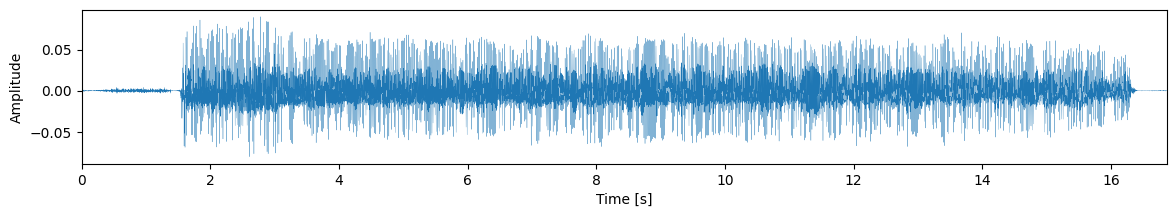

In [2]:
# Load sustained phonation recording from QPN dataset
audio_filename = "qpn_PD00020_a1.wav"
audio, sample_rate = torchaudio.load(audio_filename)

# Parameters for all figures in the document
plt.rcParams["figure.figsize"] = (14,2)
plt.rcParams['axes.xmargin'] = 0

# Downsample to reduce number of points on the plot
downsample_factor = 20
xs = torch.arange(len(audio[0,::downsample_factor])) / sample_rate * downsample_factor
plt.plot(xs, audio[0,::downsample_factor], linewidth=.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Intro

To understand how this speech analysis works, we'll step through the `vocal_characteristics` function. The very fist lines
just set up the variables needed for computation

In [3]:
# Frequency of human speech is usually between 100-300 Hz
min_f0_Hz = 80
max_f0_Hz = 300

# A new window of 0.04 second length every 0.01 seconds
step_size = 0.01
window_size = 0.05

# Do some number manipulations
step_samples = int(step_size * sample_rate)
window_samples = int(window_size * sample_rate)
max_lag = int(sample_rate / min_f0_Hz)
min_lag = int(sample_rate / max_f0_Hz)

print("Samples between (the start of) one frame and the next:", step_samples)
print("Samples contained within each frame:", window_samples)
print("Number of samples in the maximum lag:", max_lag)
print("Number of samples in the minimum lag:", min_lag)

Samples between (the start of) one frame and the next: 160
Samples contained within each frame: 800
Number of samples in the maximum lag: 200
Number of samples in the minimum lag: 53


We need at least 4 complete periods to be contained in the frame for periodic features 200 * 4 = 800

## Compute autocorrelation and related features

Autocorrelation is the cross-correlation of a signal with itself at various lags.
For harmonic signals, there are peaks at regular lag intervals corresponding to the period.
The autocorrelation ratio is the ratio of the strongest peak against the theoretical maximum
which occurs when the lag is zero.

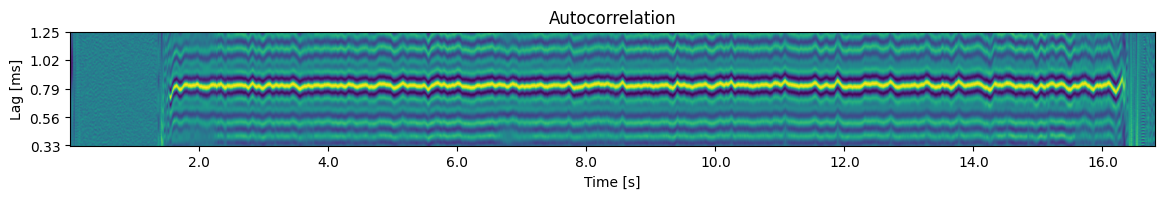

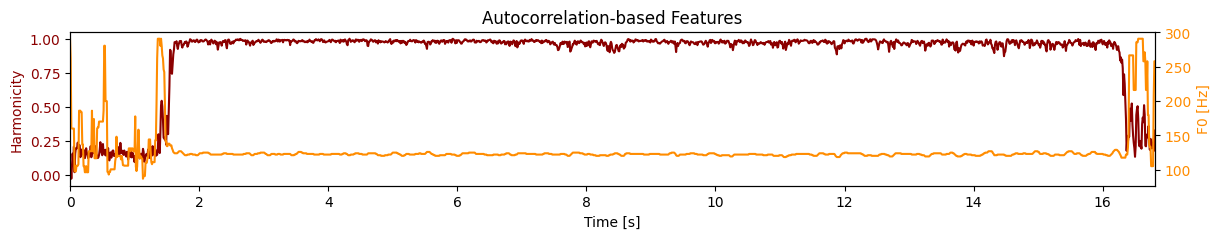

In [4]:
# Split into frames, and compute autocorrelation for each frame
frames = audio.view(1, -1).unfold(-1, window_samples, step_samples)
autocorrelation = autocorrelate(frames)

# Use autocorrelation to estimate harmonicity and best lags
harmonicity, lags = autocorrelation[:, :, min_lag:max_lag].max(dim=-1)
lags = torch.nn.functional.pad(lags, pad=(3, 3)) 
best_lags, _ = lags.unfold(-1, 7, 1).median(dim=-1)

# Re-add the min_lag back in after previous step removed it
best_lags = best_lags + min_lag
estimated_f0 = sample_rate / best_lags

xs = torch.arange(len(harmonicity[0])) * step_size

# Show autocorrelation from min lag to max lag
plt.imshow(autocorrelation[0, :, min_lag:max_lag].transpose(0,1), aspect=1.2, origin="lower")
plt.title("Autocorrelation")
plt.ylabel("Lag [ms]")
plt.xlabel("Time [s]")
xticks = (torch.arange(1, 9) * 2 / step_size).int().tolist()
plt.xticks(xticks, xs[xticks].tolist())
yticks = torch.linspace(0, max_lag - min_lag, 5).int()
plt.yticks(yticks.tolist(), ((yticks + min_lag) / 160).numpy().round(decimals=2))
plt.show()

# Show autocorrelation-based features, harmonicity (usually represented in log scale as HNR) and f0
fig, ax1 = plt.subplots()
ax1.set_title("Autocorrelation-based Features")
ax1.set_ylabel("Harmonicity", color="darkred")
ax1.set_xlabel("Time [s]")
ax1.plot(xs, harmonicity[0], color="darkred")
ax1.tick_params(axis="y", labelcolor="darkred")
ax2 = ax1.twinx()
ax2.set_ylabel("F0 [Hz]", color="darkorange")
ax2.plot(xs, estimated_f0[0], color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")
plt.show()

Average HNR: 16.2


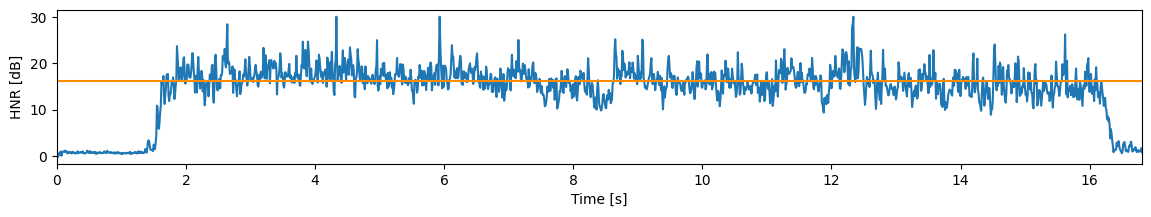

In [5]:
# Autocorrelation is the measure of harmonicity here, 1-harmonicity is noise
# See "Harmonic to Noise Ratio Measurement - Selection of Window and Length"
# By J. Fernandez, F. Teixeira, V. Guedes, A. Junior, and J. P. Teixeira
# Term is dominated by denominator, so just take -1 * log(noise)
# max value for harmonicity is 30 dB, enforced by this minimum here
noise = torch.clamp(1 - harmonicity, min=10**-3)
hnr = -10 * torch.log10(noise)

plt.plot(xs, hnr[0])
plt.xlabel("Time [s]")
plt.ylabel("HNR [dB]")

# PRAAT uses harmonicity to determine voicing in this scenario
avg_hnr = hnr[harmonicity > 0.45].mean().numpy().round(decimals=1)
plt.axhline(y=avg_hnr, color="darkorange")
print("Average HNR:", avg_hnr)

## Computing period-based features

Common periodic features are jitter and shimmer

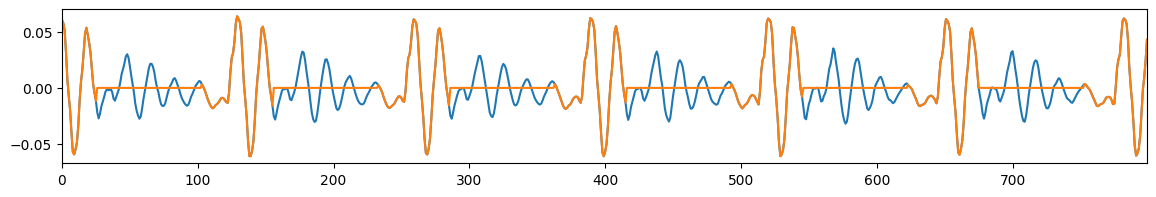

In [6]:
frame_i = 888
plt.plot(frames[0, frame_i])

# Prepare for masking
masked_frames = torch.clone(frames).detach()
mask_indices = torch.arange(frames.size(-1)).view(1, 1, -1)
mask_indices = mask_indices.expand(frames.shape)
periods = best_lags.unsqueeze(-1)
period_indices = mask_indices.remainder(periods)

# Mask everything not within about 20% (1/5) of a period peak
jitter_range = periods // 5
peak, lag = torch.max(masked_frames, dim=-1, keepdim=True)

# Handle lags close to period by checking +-1 period
lag_indices = lag.remainder(periods)
mask = (
    (period_indices < lag_indices - jitter_range)
    & (period_indices > lag_indices - periods + jitter_range)
    | (period_indices > lag_indices + jitter_range)
    & (period_indices < lag_indices + periods - jitter_range)
)
masked_frames[mask] = 0

plt.plot(masked_frames[0, frame_i])
plt.show()

tensor([336, 467,  73, 204])


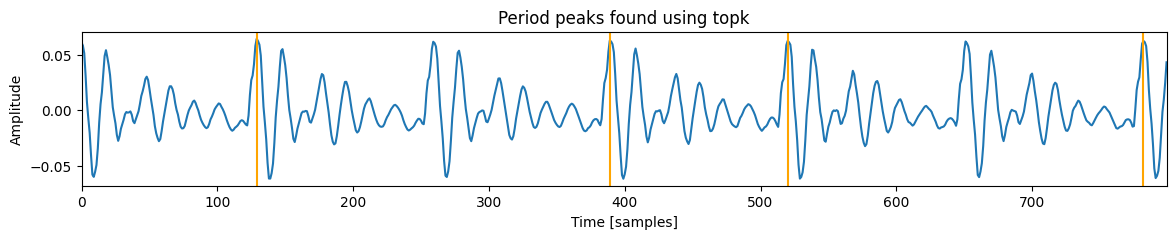

In [7]:
plt.plot(frames[0, frame_i])
peaks, lags = [], []

# Find neighboring peaks
peaks, lags = [], []
for i in range(4):
    peak, lag = torch.max(masked_frames, dim=-1, keepdim=True)
    mask = (
        (mask_indices > lag - periods // 2)
        & (mask_indices < lag + periods // 2)
    )
    masked_frames[mask] = 0
    peaks.append(peak.squeeze(-1))
    lags.append(lag.squeeze(-1))

peaks = torch.stack(peaks, dim=-1)
lags = torch.stack(lags, dim=-1)

for lag in lags[0, frame_i]:
    plt.axvline(lag, color="orange")

plt.title("Period peaks found using topk")
plt.xlabel("Time [samples]")
plt.ylabel("Amplitude")
print(lags[0, 230])

In [8]:
# Jitter = average variation in period length
# Compute mean difference from mean lag, normalized by period
# Use minimum here to avoid wraparound errors
lags = lags.remainder(periods)
lags = torch.minimum(lags, periods - lags)
jitter_frames = (lags - lags.float().mean(dim=-1, keepdims=True)).abs()
jitter = jitter_frames.mean(dim=-1) / best_lags

print(lags[0, frame_i])
print(jitter_frames[0, frame_i] / best_lags[0, frame_i])
print(jitter[0, frame_i])

tensor([1, 1, 2, 0])
tensor([0.0000, 0.0000, 0.0077, 0.0077])
tensor(0.0038)


Average Jitter: 0.46%


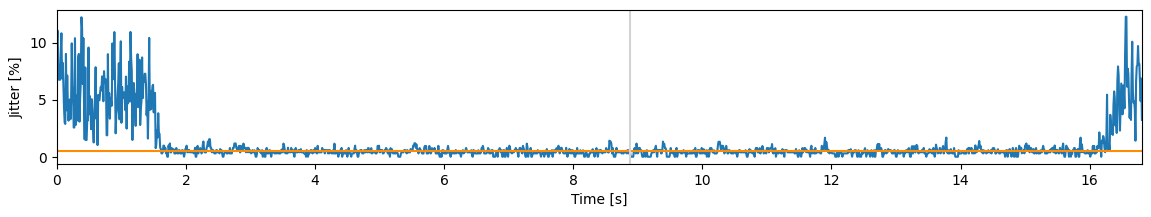

In [9]:
plt.plot(xs, jitter[0] * 100)
plt.xlabel("Time [s]")
plt.ylabel("Jitter [%]")
plt.axhline(y = jitter[jitter < 0.02].mean() * 100, color="darkorange")
plt.axvline(x = frame_i / 100, color="lightgrey")
print("Average Jitter: {0:.2f}%".format(100 * jitter[jitter < 0.02].mean().numpy()))

In [10]:
# Shimmer = average variation in amplitude, normalized by avg amplitude
avg_amps = peaks.mean(dim=-1, keepdims=True)
amp_diff = (peaks - avg_amps).abs()
shimmer = amp_diff.mean(dim=-1) / avg_amps.squeeze(-1).clamp(min=1e-3)

print(amp_diff[0, frame_i] / avg_amps[0, frame_i])
print(shimmer[0, frame_i])

tensor([0.0226, 0.0046, 0.0085, 0.0095])
tensor(0.0113)


Average Shimmer: 2.01%


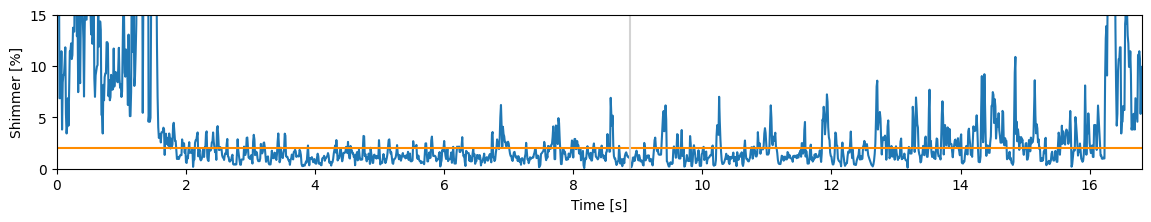

In [11]:
# PRAAT uses jitter < 0.02 for voicing decision
plt.plot(xs, shimmer[0] * 100)
plt.xlabel("Time [s]")
plt.ylabel("Shimmer [%]")
plt.ylim((0, 15))
plt.axhline(y = shimmer[jitter < 0.02].mean() * 100, color="darkorange")
plt.axvline(x = frame_i / 100, color="lightgrey")
print("Average Shimmer: {0:.2f}%".format(100 * shimmer[jitter < 0.02].mean().numpy()))

## Compute GNE step-by-step

The algorithm is best described in "The Effectiveness of the Glottal to Noise Excitation Ratio for the Screening of Voice Disorders" by Godino-Llorente et al.


In [12]:
# Step 1. Downsample to 10 kHz since voice energy is low above 5 kHz
new_sample_rate = 10000
audio, sample_rate = torchaudio.load(audio_filename)
downsampled_audio = torchaudio.functional.resample(audio, 16000, new_sample_rate)

Text(0, 0.5, 'Amplitude')

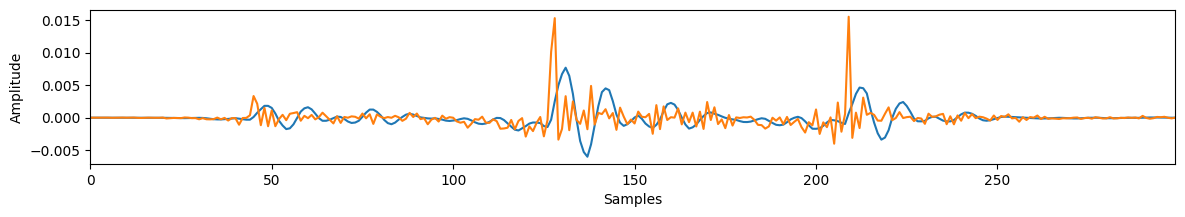

In [13]:
# Step 2. Inverse filter with 30-msec window, 10-msec hop and 13th order LPC
frame_size, hop_size, lpc_order = 300, 100, 13

# Solve for LPC coefficients
window = torch.hann_window(frame_size).view(1, 1, -1)
downsampled_audio = torch.nn.functional.pad(downsampled_audio, (0, frame_size))
frames = downsampled_audio.view(1, -1).unfold(-1, frame_size, hop_size) * window

autocorrelation = compute_cross_correlation(frames, frames, width=lpc_order)

# Collapse frame and batch into same dimension, for lfiltering
batch, frame_count, _ = autocorrelation.shape
autocorrelation = autocorrelation.view(batch * frame_count, -1)

# An autocorrelation of all 0's -- which can happen in padding -- leads to
# an error with the linear system solver, as the matrix is singular
# We fix this by ensuring the zero-lag correlation is always 1
autocorrelation[:, lpc_order] = 1.0 

# Construct Toeplitz matrices (one per frame)
# This is [[p0, p1, p2...], [p1, p0, p1...], [p2, p1, p0...] ...]
# Our sliding window should go from the end to the front, so flip
# The autocorrelation has an extra value on each end for our prediction values
R = autocorrelation[:, 1: -1].unfold(-1, lpc_order, 1).flip(dims=(1,))
r = autocorrelation[:, lpc_order + 1:]

# Solve for LPC coefficients, generate inverse filter with coeffs 1, -a_1, ...
lpc = torch.linalg.solve(R, r)
a_coeffs = torch.cat((torch.ones(lpc.size(0), 1), -lpc), dim=1)
b_coeffs = torch.zeros_like(a_coeffs)
b_coeffs[:, 0] = 1

# Perform filtering
excitation = torchaudio.functional.lfilter(frames, b_coeffs, a_coeffs, clamp=False)
plt.plot(frames[0, 200, :] * 0.1)
plt.plot(excitation[0, 200, :])
plt.xlabel("Samples")
plt.ylabel("Amplitude")

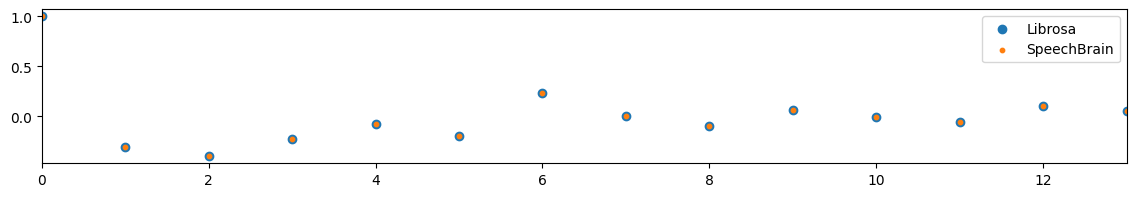

In [14]:
# Just prove that we correctly calculated the coefficients
import librosa

librosa_coeffs = librosa.lpc(frames[0, 0].numpy(), order=lpc_order)
plt.scatter(torch.arange(lpc_order + 1), librosa_coeffs)
plt.scatter(torch.arange(lpc_order + 1), a_coeffs[0], s=10)
plt.legend(["Librosa", "SpeechBrain"])
plt.show()

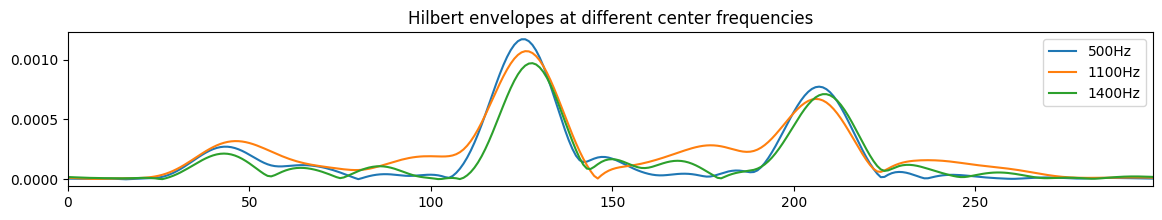

In [15]:
# Step 3. Compute Hilbert envelopes for each frequency bin
bandwidth = 1000
fshift = 300
min_freq, max_freq = bandwidth // 2, new_sample_rate // 2 - bandwidth // 2
center_freqs = range(min_freq, max_freq, fshift)
envelopes = {
    center_freq: compute_hilbert_envelopes(
        excitation, center_freq, bandwidth, new_sample_rate
    )
    for center_freq in center_freqs
}
plt.plot(envelopes[500][0, 200])
plt.plot(envelopes[1100][0, 200])
plt.plot(envelopes[1400][0, 200])
plt.legend(["500Hz", "1100Hz", "1400Hz"])
plt.title("Hilbert envelopes at different center frequencies")
plt.show()

In [16]:
# Step 4. Compute cross correlation between (non-neighboring) frequency bins
correlations = [
    compute_cross_correlation(envelopes[freq_i], envelopes[freq_j], width=3)
    for freq_i in center_freqs
    for freq_j in center_freqs
    if (freq_j - freq_i) > bandwidth // 2
]

# Step 5. The maximum cross-correlation is the GNE score
gne = torch.stack(correlations, dim=-1).amax(dim=(1, 2))
gne = 10 * torch.log10(1 - gne)

tensor(21.9147)


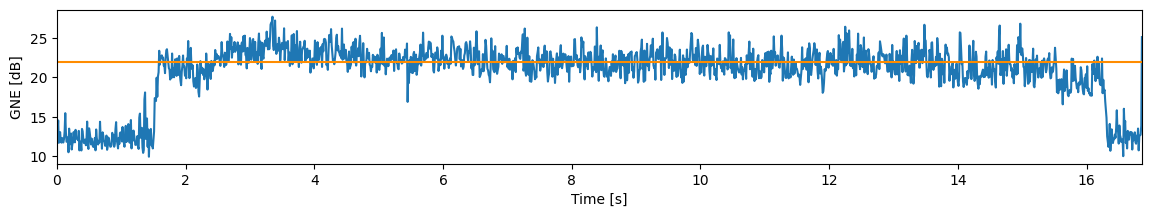

In [17]:
new_step_size = hop_size / new_sample_rate
gne_xs = torch.arange(len(gne[0])) * new_step_size
plt.plot(gne_xs, gne[0])
plt.xlabel("Time [s]")
plt.ylabel("GNE [dB]")
plt.axhline(gne[gne > 15].mean(), color="darkorange")
print(gne[gne > 15].mean())

## PRAAT-Parselmouth

We'll run a similar analysis to verify that our numbers look accurate.

In [18]:
import parselmouth
from parselmouth.praat import call
import numpy as np

# Bundle these to compute them again later
def compute_praat_features(audio_filename):
    f0min = 75
    f0max = 300
    
    sound = parselmouth.Sound(audio_filename)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    pitch = sound.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan

    jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    harmonicity = sound.to_harmonicity()

    return pitch.xs(), pitch_values, jitter, shimmer, harmonicity


pitch_xs, pitch_values, praat_jitter, praat_shimmer, harmonicity = compute_praat_features(audio_filename)

Estimated average frequency (SpeechBrain): 122.7 Hz
Estimated average frequency (PRAAT): 122.7 Hz


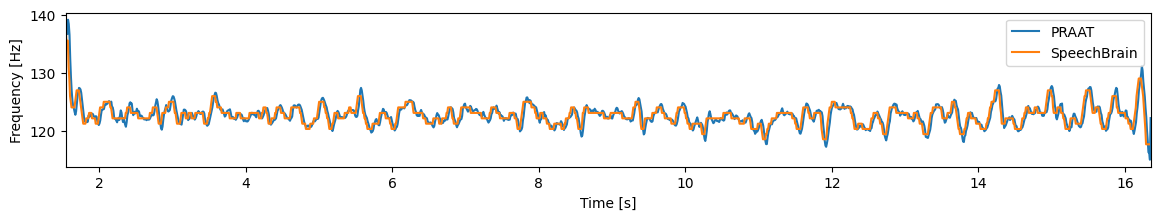

In [19]:
# Pitch comparison
plt.plot(pitch_xs, pitch_values)
voiced = np.isfinite(pitch_values)[:-1]
plt.plot(xs[voiced], estimated_f0[0, voiced])
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.legend(["PRAAT", "SpeechBrain"])

print("Estimated average frequency (SpeechBrain): {0:.1f} Hz".format(estimated_f0[0, voiced].mean().numpy()))
print("Estimated average frequency (PRAAT): {0:.1f} Hz".format(np.nanmean(pitch_values)))

In [20]:
print("Average Jitter (SpeechBrain): {0:.2f}%".format(100 * jitter[0, voiced].mean().numpy()))
print("Average Jitter (PRAAT): {0:.2f}%".format(100 * praat_jitter))

Average Jitter (SpeechBrain): 0.47%
Average Jitter (PRAAT): 0.46%


In [21]:
print("Average Shimmer (SpeechBrain): {0:.2f}%".format(100 * shimmer[0, voiced].mean().numpy()))
print("Average Shimmer (PRAAT): {0:.2f}%".format(100 * praat_shimmer))

Average Shimmer (SpeechBrain): 1.92%
Average Shimmer (PRAAT): 2.74%


Average HNR (SpeechBrain): 16.3%
Average HNR (PRAAT): 19.3%


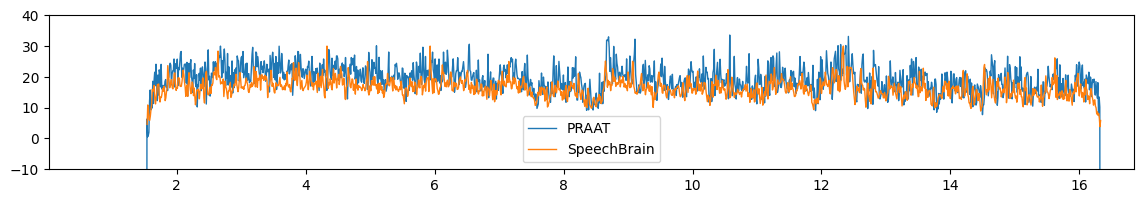

In [22]:
praat_hnr = call(harmonicity, "Get mean", 0, 0)
plt.plot(harmonicity.xs(), harmonicity.values.T, linewidth=1)
plt.plot(xs[voiced], hnr[0, voiced], linewidth=1)
plt.ylim((-10, 40))
plt.legend(["PRAAT", "SpeechBrain"])
print("Average HNR (SpeechBrain): {0:.1f}%".format(hnr[0, voiced].mean().numpy()))
print("Average HNR (PRAAT): {0:.1f}%".format(praat_hnr))

## OpenSMILE

In [23]:
import opensmile

opensmile_extractor = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

opensmile_feats = opensmile_extractor.process_file(audio_filename)
opensmile_feats.shape

(1682, 25)

In [24]:
opensmile_feats.columns

Index(['Loudness_sma3', 'alphaRatio_sma3', 'hammarbergIndex_sma3',
       'slope0-500_sma3', 'slope500-1500_sma3', 'spectralFlux_sma3',
       'mfcc1_sma3', 'mfcc2_sma3', 'mfcc3_sma3', 'mfcc4_sma3',
       'F0semitoneFrom27.5Hz_sma3nz', 'jitterLocal_sma3nz',
       'shimmerLocaldB_sma3nz', 'HNRdBACF_sma3nz', 'logRelF0-H1-H2_sma3nz',
       'logRelF0-H1-A3_sma3nz', 'F1frequency_sma3nz', 'F1bandwidth_sma3nz',
       'F1amplitudeLogRelF0_sma3nz', 'F2frequency_sma3nz',
       'F2bandwidth_sma3nz', 'F2amplitudeLogRelF0_sma3nz',
       'F3frequency_sma3nz', 'F3bandwidth_sma3nz',
       'F3amplitudeLogRelF0_sma3nz'],
      dtype='object')

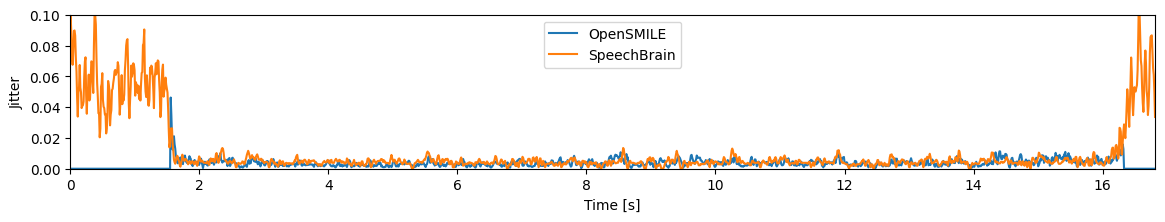

In [25]:
os_xs = opensmile_feats.index.get_level_values("start").total_seconds()
jitter_sma3 = torch.nn.functional.avg_pool1d(jitter, kernel_size=3, padding=1, stride=1)
plt.plot(os_xs, opensmile_feats.jitterLocal_sma3nz)
plt.plot(xs, jitter_sma3[0])
plt.ylim((0, 0.1))
plt.xlabel("Time [s]")
plt.ylabel("Jitter")
plt.legend(["OpenSMILE", "SpeechBrain"])

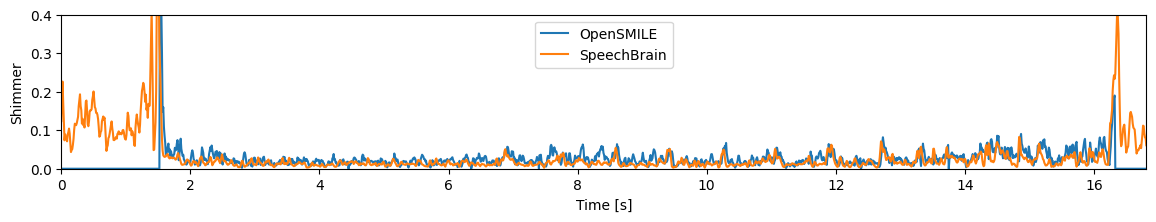

In [26]:
# From the name, it looks like shimmer should be in dB but the curve does not look it. Dividing by 10 is roughly the same.
plt.plot(os_xs, opensmile_feats.shimmerLocaldB_sma3nz / 10)
shimmer_sma3 = torch.nn.functional.avg_pool1d(shimmer, kernel_size=3, padding=1, stride=1)
plt.plot(xs, shimmer_sma3[0])
plt.ylim((0, 0.4))
plt.xlabel("Time [s]")
plt.ylabel("Shimmer")
plt.legend(["OpenSMILE", "SpeechBrain"])

8.967940330505371


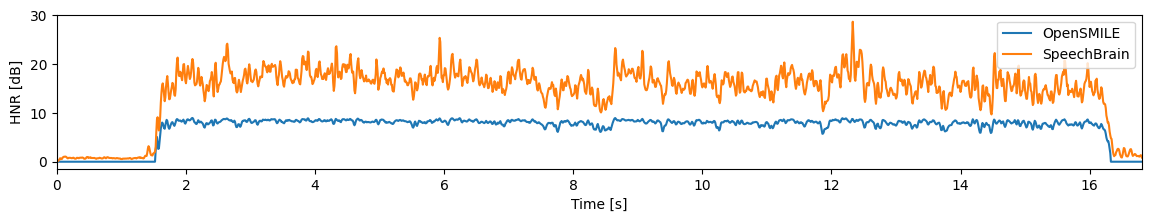

In [27]:
# Looks like there's a cap of ~10 dB for the openSmile features,
# or maybe they x10 instead of 10log10(1-x) like the shimmer
plt.plot(os_xs, opensmile_feats.HNRdBACF_sma3nz)
hnr_sma3 = torch.nn.functional.avg_pool1d(hnr, kernel_size=3, padding=1, stride=1)
plt.plot(xs, hnr_sma3[0])
plt.xlabel("Time [s]")
plt.ylabel("HNR [dB]")
plt.legend(["OpenSMILE", "SpeechBrain"])
print(max(opensmile_feats.HNRdBACF_sma3nz))

## Difficult Example

To further verify that we are able to closely match the PRAAT vocal characteristics, we compute the same statistics for a more difficult example. The "voiced" and pitch computation is very difficult, even ambiguous, in this example due to numerous voice breaks. However, we want to at least show similar jitter, shimmer, and hnr values.

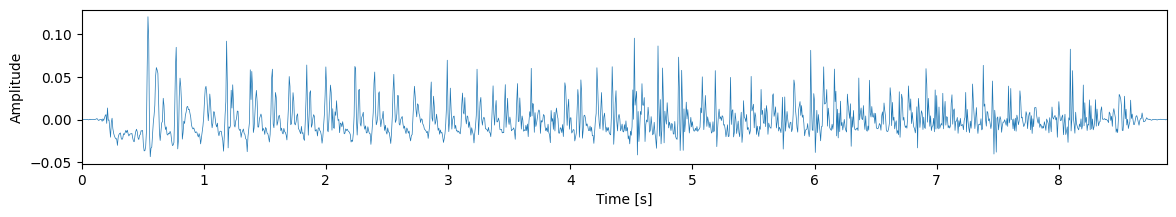

In [28]:
audio_filename = "qpn_MNI0144_a1.wav"
audio, sample_rate = torchaudio.load(audio_filename)

# Downsample to reduce number of points on the plot
downsample_factor = 100
xs = torch.arange(len(audio[0,::downsample_factor])) / sample_rate * downsample_factor
plt.plot(xs, audio[0,::downsample_factor], linewidth=.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

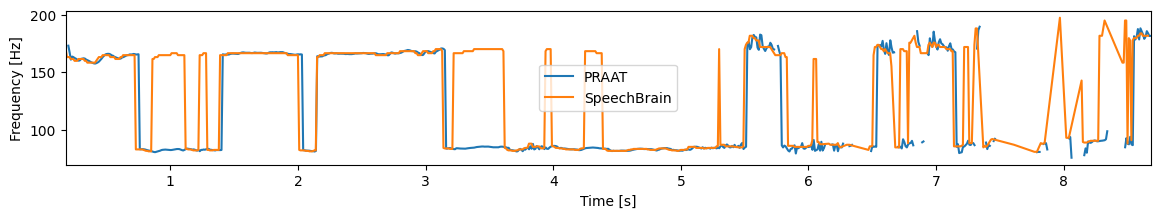

In [29]:
frames = audio.unfold(-1, window_samples, step_samples)
harmonicity, best_lags = compute_autocorr_features(frames, min_lag, max_lag)
estimated_f0 = sample_rate / best_lags
jitter, shimmer = compute_periodic_features(frames, best_lags)
hnr = -10 * (1 - harmonicity).clamp(min=1e-3).log10()
pitch_xs, pitch_values, praat_jitter, praat_shimmer, harmonicity = compute_praat_features(audio_filename)

xs = torch.arange(len(frames[0])) * step_size
voiced = np.isfinite(pitch_values)[:-1]
plt.plot(pitch_xs, pitch_values)
plt.plot(xs[voiced], estimated_f0[0, voiced])
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.legend(["PRAAT", "SpeechBrain"])
plt.show()

In [30]:
# Jitter is not too far off
print("Average Jitter (SpeechBrain): {0:.2f}%".format(100 * jitter[0, voiced].mean().numpy()))
print("Average Jitter (PRAAT): {0:.2f}%".format(100 * praat_jitter))

Average Jitter (SpeechBrain): 1.38%
Average Jitter (PRAAT): 1.56%


In [31]:
# Shimmer is little further but still fairly close
print("Average Shimmer (SpeechBrain): {0:.2f}%".format(100 * shimmer[0, voiced].mean().numpy()))
print("Average Shimmer (PRAAT): {0:.2f}%".format(100 * praat_shimmer))

Average Shimmer (SpeechBrain): 8.58%
Average Shimmer (PRAAT): 7.03%


Average HNR (SpeechBrain): 13.7%
Average HNR (PRAAT): 15.1%


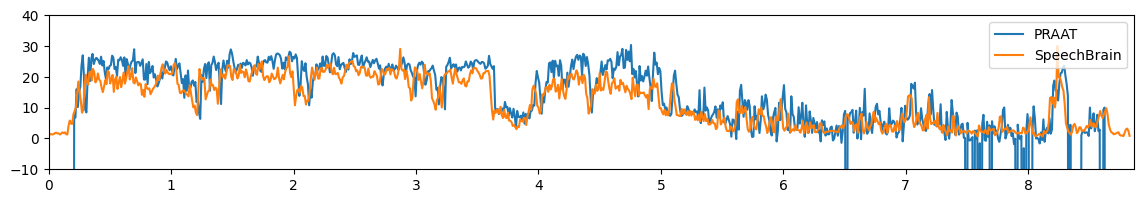

In [32]:
praat_hnr = call(harmonicity, "Get mean", 0, 0)
plt.plot(harmonicity.xs(), harmonicity.values.T)
plt.plot(xs, hnr)
plt.ylim((-10, 40))
plt.legend(["PRAAT", "SpeechBrain"])
print("Average HNR (SpeechBrain): {0:.1f}%".format(hnr[0, voiced].mean().numpy()))
print("Average HNR (PRAAT): {0:.1f}%".format(praat_hnr))

tensor(16.3677)


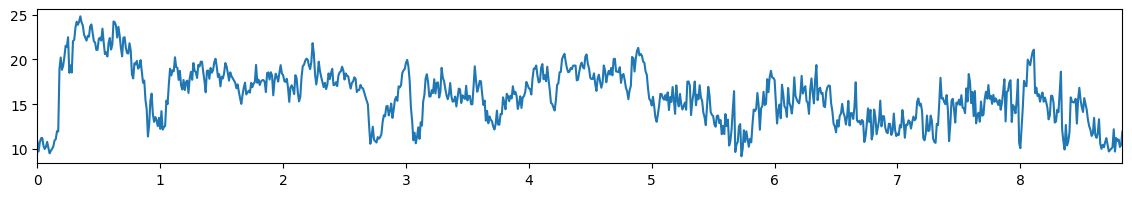

In [33]:
gne = compute_gne(audio, frame_len=window_size, hop_len=step_size)
gne = -10 * (1 - gne).clamp(min=1e-3).log10()
plt.plot(xs, gne[0])
print(gne[0, voiced].mean())

In [34]:
opensmile_feats = opensmile_extractor.process_file(audio_filename)

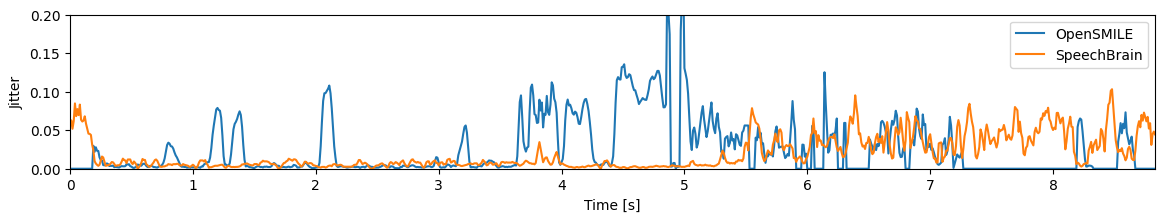

In [35]:
os_xs = opensmile_feats.index.get_level_values("start").total_seconds()
jitter_sma3 = torch.nn.functional.avg_pool1d(jitter, kernel_size=3, padding=1, stride=1)
plt.plot(os_xs, opensmile_feats.jitterLocal_sma3nz)
plt.plot(xs, jitter_sma3[0])
plt.ylim((0, 0.2))
plt.xlabel("Time [s]")
plt.ylabel("Jitter")
plt.legend(["OpenSMILE", "SpeechBrain"])

so I figured out that OpenSMILE window isn't long enough to fit the long periods of this sample, causing it to overestimate the jitter (e.g. around 4 seconds). This is also the reason that there is such high correlation between jitter and shimmer for this sample in OpenSMILE. When I decrease the size of the speechbrain analysis window I get a similar pattern.

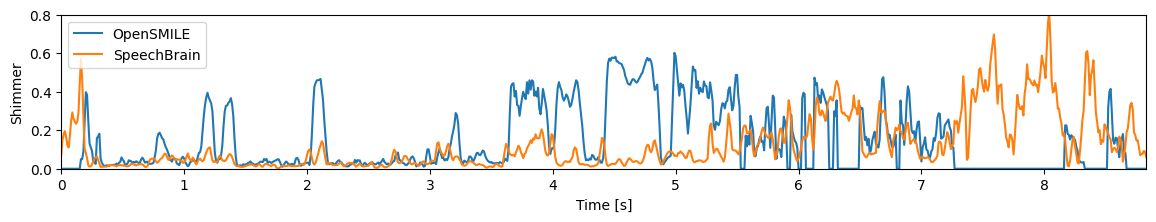

In [36]:
# From the name, it looks like shimmer should be in dB but the curve does not look it. Dividing by 10 is roughly the same.
plt.plot(os_xs, opensmile_feats.shimmerLocaldB_sma3nz / 10)
shimmer_sma3 = torch.nn.functional.avg_pool1d(shimmer, kernel_size=3, padding=1, stride=1)
plt.plot(xs, shimmer_sma3[0])
plt.ylim((0, 0.8))
plt.xlabel("Time [s]")
plt.ylabel("Shimmer")
plt.legend(["OpenSMILE", "SpeechBrain"])

11.674199104309082


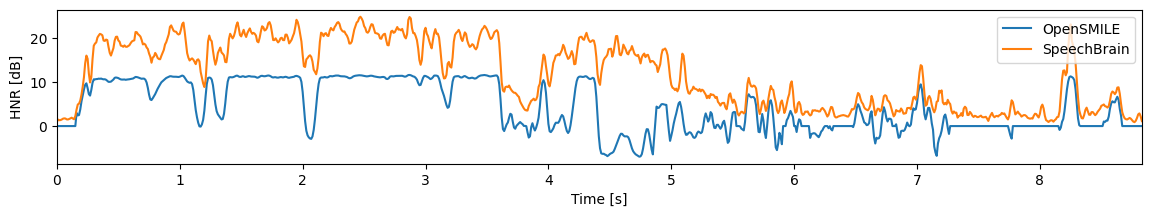

In [37]:
# Looks like there's a cap of ~10 dB for the openSmile features,
# or maybe they x10 instead of 10log10(1-x) like the shimmer
plt.plot(os_xs, opensmile_feats.HNRdBACF_sma3nz)
hnr_sma3 = torch.nn.functional.avg_pool1d(hnr, kernel_size=3, padding=1, stride=1)
plt.plot(xs, hnr_sma3[0])
plt.xlabel("Time [s]")
plt.ylabel("HNR [dB]")
plt.legend(["OpenSMILE", "SpeechBrain"])
print(max(opensmile_feats.HNRdBACF_sma3nz))

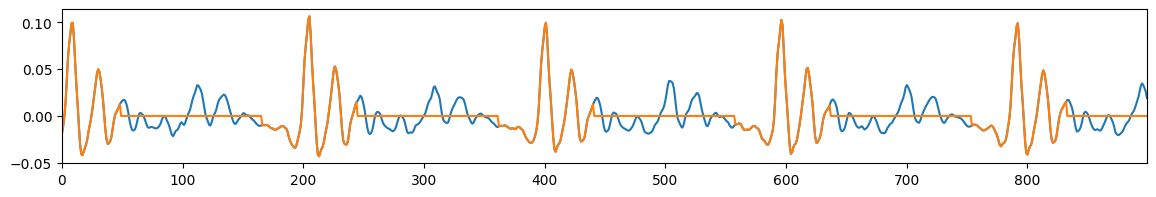

In [38]:
# Split into frames, and compute autocorrelation for each frame
audio = torch.nn.functional.pad(audio, (0, window_samples + 100))
frames = audio.unfold(-1, window_samples + 100, step_samples)
autocorrelation = autocorrelate(frames)

# Use autocorrelation to estimate harmonicity and best lags
harmonicity, lags = autocorrelation[:, :, min_lag:max_lag].max(dim=-1)
lags = torch.nn.functional.pad(lags, pad=(3, 3)) 
best_lags, _ = lags.unfold(-1, 7, 1).median(dim=-1)
best_lags += min_lag
frame_i = 450
plt.plot(frames[0, frame_i])

# Prepare for masking
masked_frames = torch.clone(frames).detach()
mask_indices = torch.arange(frames.size(-1)).view(1, 1, -1)
mask_indices = mask_indices.expand(frames.shape)
periods = best_lags.unsqueeze(-1)
period_indices = mask_indices.remainder(periods)

# Mask everything not within about 20% (1/5) of a period peak
jitter_range = periods // 5
peak, lag = torch.max(masked_frames, dim=-1, keepdim=True)

# Handle lags close to period by checking +-1 period
lag_indices = lag.remainder(periods)
mask = (
    (period_indices < lag_indices - jitter_range)
    & (period_indices > lag_indices - periods + jitter_range)
    | (period_indices > lag_indices + jitter_range)
    & (period_indices < lag_indices + periods - jitter_range)
)
masked_frames[mask] = 0

plt.plot(masked_frames[0, frame_i])
plt.show()

tensor([731,  58, 538, 154])


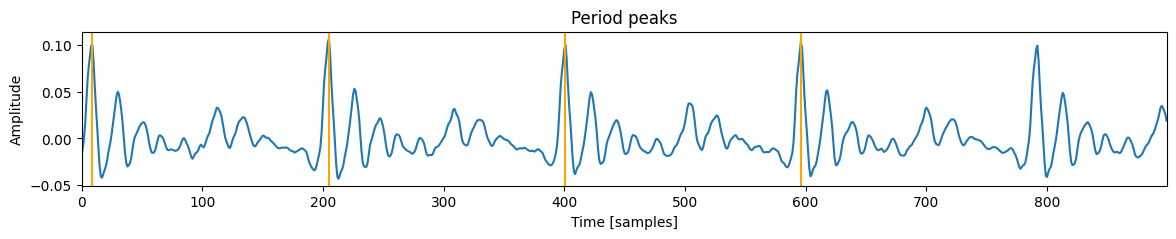

In [39]:
plt.plot(frames[0, frame_i])
peaks, lags = [], []

# Find neighboring peaks
peaks, lags = [], []
for i in range(4):
    peak, lag = torch.max(masked_frames, dim=-1, keepdim=True)
    mask = (
        (mask_indices > lag - periods // 2)
        & (mask_indices < lag + periods // 2)
    )
    masked_frames[mask] = 0
    peaks.append(peak.squeeze(-1))
    lags.append(lag.squeeze(-1))

peaks = torch.stack(peaks, dim=-1)
lags = torch.stack(lags, dim=-1)

for lag in lags[0, frame_i]:
    plt.axvline(lag, color="orange")

plt.title("Period peaks")
plt.xlabel("Time [samples]")
plt.ylabel("Amplitude")
print(lags[0, 230])

In [40]:
# Jitter = average variation in period length
# Compute mean difference from mean lag, normalized by period
# Use minimum here to avoid wraparound errors
lags = lags.remainder(periods)
lags = torch.minimum(lags, periods - lags)
jitter_frames = (lags - lags.float().mean(dim=-1, keepdims=True)).abs()
jitter = jitter_frames.mean(dim=-1) / best_lags

print(lags[0, frame_i])
print(jitter_frames[0, frame_i] / best_lags[0, frame_i])
print(jitter[0, frame_i])

tensor([9, 8, 9, 9])
tensor([0.0013, 0.0038, 0.0013, 0.0013])
tensor(0.0019)


## Stats over QPN dataset

We show the stats are similar when computed over the full dataset too.

In [41]:
from getpass import getpass

data_folder = getpass("Enter data folder:")

Enter data folder: ········


In [42]:
import glob
import time
import os

import opensmile

from speechbrain.lobes.features import VocalFeatures

samples = {}

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

sb_features = VocalFeatures().to("cuda")

for filename in glob.glob(data_folder + "/Batch[12]/Segmented/*_a[123].wav"):

    # Include file loading in speechbrain timing for fairness
    start = time.time()
    audio, sample_rate = torchaudio.load(filename)
    basename = os.path.basename(filename)
    _, pid, trial = basename[:-len(".wav")].split("_")

    # Take one second off front and back to avoid silence
    audio = audio[:, sample_rate: -sample_rate]
    sb_feats = sb_features(audio.to("cuda")).squeeze(0).cpu()
    sb_end = time.time()

    # PRAAT
    pitch_xs, pitch_values, praat_jitter, praat_shimmer, harmonicity = compute_praat_features(filename)
    praat_end = time.time()

    # OpenSmile
    opensmile_feats = smile.process_file(filename)
    opensmile_end = time.time()
    
    praat_hnr = harmonicity.values.T.mean()
    
    if pid not in samples:
        samples[pid] = {}

    samples[pid][trial] = {
        "sb_means": sb_feats.mean(dim=0),
        "sb_stds": sb_feats.std(dim=0),
        "sb_time": sb_end - start,
        "praat_jitter": praat_jitter,
        "praat_shimmer": praat_shimmer,
        "praat_hnr": praat_hnr,
        "praat_time": praat_end - sb_end,
    }

/home/competerscience/Documents/Repositories/speechbrain/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


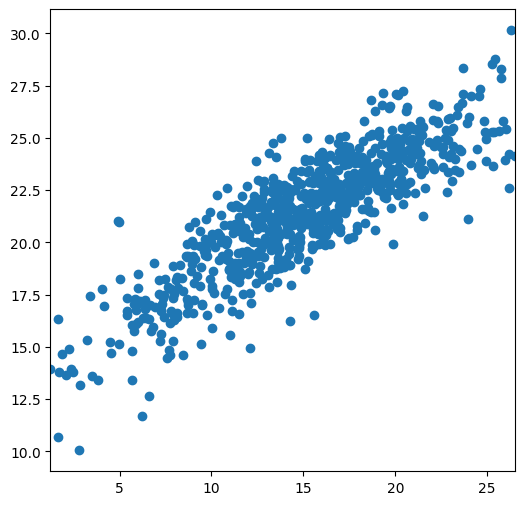

In [43]:
plt.rcParams["figure.figsize"] = (6,6)

def flatten(samples, index):
    return [samples[pid][trial][index] for pid in samples for trial in samples[pid]]
def flatten_sb(samples, index, feat_index):
    return [samples[pid][trial][index][feat_index] for pid in samples for trial in samples[pid]]
plt.scatter(flatten_sb(samples, "sb_means", 1), flatten(samples, "praat_jitter"))
#plt.xlim((0, 0.1))

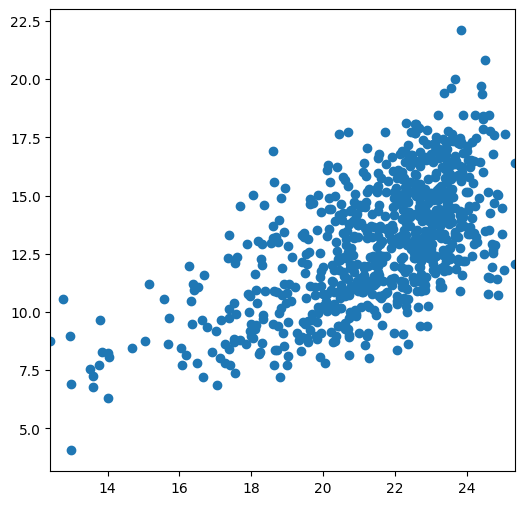

In [44]:
plt.scatter(flatten_sb(samples, "sb_means", 2), flatten(samples, "praat_shimmer"))
#plt.ylim((0, 0.4))

(array([  0., 658., 114.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18]),
 <BarContainer object of 9 artists>)

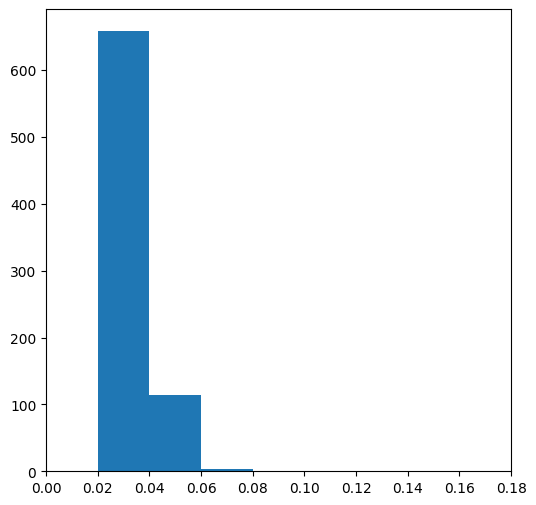

In [45]:
plt.hist(flatten(samples, "sb_time"), bins=np.arange(0, 0.2, 0.02))

(array([  8.,  88., 189., 240., 116.,  66.,  32.,  22.,  12.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18]),
 <BarContainer object of 9 artists>)

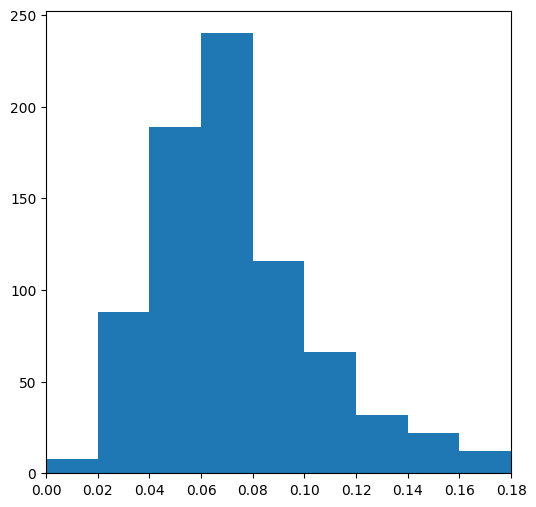

In [46]:
plt.hist(flatten(samples, "praat_time"), bins=np.arange(0, 0.2, 0.02))

(array([ 66., 212., 262., 122.,  69.,  28.,  10.,   6.,   0.,   3.]),
 array([0.04332185, 0.12552581, 0.20772977, 0.28993373, 0.37213769,
        0.45434165, 0.53654561, 0.61874957, 0.70095353, 0.78315749,
        0.86536145]),
 <BarContainer object of 10 artists>)

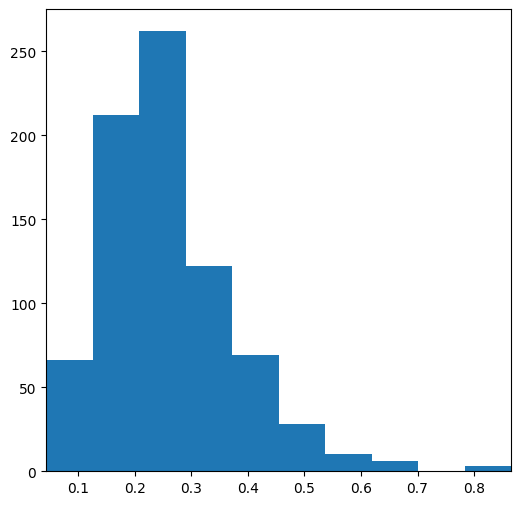

In [47]:
plt.hist(flatten(samples, "opensmile_time"))

## Compute predictiveness

So we will do this for both detection and regression. First separate by PD/non-PD, then correlate with functional score. 

In [48]:
import pandas

batch1 = pandas.read_csv(os.path.join(data_folder, "QPN_Batch1.csv"), index_col=0)
batch2 = pandas.read_csv(os.path.join(data_folder, "QPN_Batch2-demographic.csv"), index_col=0)
qpn = pandas.concat([batch1, batch2]).groupby("pid").last()
qpn.replace({"CTRL": "control", "PD": "patient"}, inplace=True)
len(qpn)

276

In [59]:
xs, ys = [], []
xs2, ys2 = [], []
for pid in qpn.index:
    if qpn.loc[pid].group == "control" and pid in samples:
        for trial in samples[pid]:
            xs.append(samples[pid][trial]["sb_means"][1])
            ys.append(samples[pid][trial]["sb_means"][12])
    elif qpn.loc[pid].group == "patient" and pid in samples:
        for trial in samples[pid]:
            xs2.append(samples[pid][trial]["sb_means"][1])
            ys2.append(samples[pid][trial]["sb_means"][12])

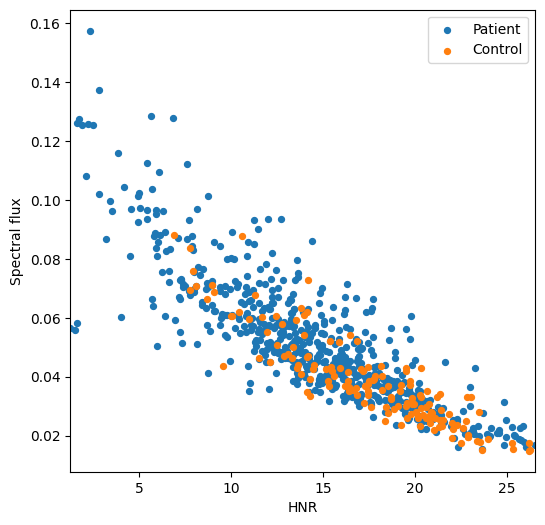

In [60]:
plt.scatter(xs2, ys2, s=18)
plt.scatter(xs, ys, s=18)
#plt.ylim((0, 100))
#plt.xlim((0, 0.3))
plt.xlabel("HNR")
plt.ylabel("Spectral flux")
plt.legend(["Patient", "Control"])

## XGBoost

What if we did very basic prediction

In [51]:
# Find which are test samples
test_files = glob.glob(os.path.join(data_folder, "Neuro_split", "test_*", "Batch*", "*_a1.wav"))
test_ids = [os.path.basename(f).split("_")[1] for f in test_files]
len(test_ids)

32

In [52]:
samples["PD00020"]["a1"]["opensmile"].values.shape

(1, 88)

In [97]:
# Collect features
xs, ys = [], []
test_xs, test_ys = [], []
for pid in qpn.index:
    if qpn.loc[pid].group == "control" and pid in samples:
        y = 0
    elif qpn.loc[pid].group == "patient" and pid in samples:
        y = 1
    else:
        continue
        
    #row = [qpn.loc[pid].age]
    row = []

    for field in ["sb_shimmer", "sb_jitter", "sb_hnr", "sb_gne"]:
        #row.extend(np.mean([samples[pid][t][field] for t in samples[pid]], axis=0))
        row.extend(np.mean([samples[pid][t][field + "_voiced"] for t in samples[pid]], axis=0))
    
        for field in ["opensmile"]:
            row.extend(samples[pid][t][field].values[0])
            #row.append(1 if qpn.loc[pid].gender == "M" or qpn.loc[pid].sex == "M" else 0)
        
        if pid in test_ids:
            test_xs.append(row)
            test_ys.append(y)
    
            if qpn.loc[pid].gender == "M" or qpn.loc[pid].sex == "M":
                test_xs_m.append(row)
                test_ys_m.append(y)
            if qpn.loc[pid].gender == "F" or qpn.loc[pid].sex == "F":
                test_xs_f.append(row)
                test_ys_f.append(y)
    
            if qpn.loc[pid].Language_used == "English" or qpn.loc[pid].first_language == "EN":
                test_xs_en.append(row)
                test_ys_en.append(y)
            if qpn.loc[pid].Language_used == "French" or qpn.loc[pid].first_language == "FR":
                test_xs_fr.append(row)
                test_ys_fr.append(y)
        elif pid in valid_ids:
            valid_xs.append(row)
            valid_ys.append(y)
        else:
            xs.append(row)
            ys.append(y)

In [98]:
np.array(xs).shape

(623, 88)

In [100]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(scale_pos_weight=0.1)
xgb.fit(xs, ys)
predictions = xgb.predict(test_xs)
accuracy = accuracy_score(test_ys, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.75%


In [94]:
# Collect features
xs, ys = [], []
test_xs, test_ys = [], []
valid_xs, valid_ys = [], []
test_xs_m, test_ys_m, test_xs_f, test_ys_f = [], [], [], []
test_xs_en, test_ys_en, test_xs_fr, test_ys_fr = [], [], [], []
for pid in qpn.index:
    if pid not in samples:
        continue
        
    if qpn.loc[pid].group == "control":
        y = 0
    elif qpn.loc[pid].group == "patient":
        y = 1
    else:
        continue
        
    for t in samples[pid]:
        row = []
        row.extend(samples[pid][t]["sb_means"].numpy())
        row.extend(samples[pid][t]["sb_stds"].numpy())
        row.append(1 if qpn.loc[pid].gender == "M" else 0)
        
        if pid in test_ids:
            test_xs.append(row)
            test_ys.append(y)
    
            if qpn.loc[pid].gender == "M" or qpn.loc[pid].sex == "M":
                test_xs_m.append(row)
                test_ys_m.append(y)
            if qpn.loc[pid].gender == "F" or qpn.loc[pid].sex == "F":
                test_xs_f.append(row)
                test_ys_f.append(y)
    
            if qpn.loc[pid].Language_used == "English" or qpn.loc[pid].first_language == "EN":
                test_xs_en.append(row)
                test_ys_en.append(y)
            if qpn.loc[pid].Language_used == "French" or qpn.loc[pid].first_language == "FR":
                test_xs_fr.append(row)
                test_ys_fr.append(y)
        elif pid in valid_ids:
            valid_xs.append(row)
            valid_ys.append(y)
        else:
            # quadruple-sample male controls
            if qpn.loc[pid].gender == "M" and y == 0:
                xs.append(row)
                ys.append(y)
                xs.append(row)
                ys.append(y)
                xs.append(row)
                ys.append(y)
                xs.append(row)
                ys.append(y)
            else:
                xs.append(row)
                ys.append(y)

In [95]:
len(row)

35

In [96]:
avg, avg_m, avg_f, avg_en, avg_fr = 0, 0, 0, 0, 0
for i in range(100):
    xgb = XGBClassifier(scale_pos_weight=0.25, n_estimators=5, learning_rate=0.1, max_depth=5, random_state=i, subsample=0.8)
 
    xgb.fit(xs, ys, eval_set=[(valid_xs, valid_ys)], verbose=0)
    predictions = xgb.predict(test_xs)
    accuracy = accuracy_score(test_ys, predictions)
    avg += accuracy
    #print("Accuracy: %.2f%%" % accuracy)
    
    # Check gender distribution
    predictions_m = xgb.predict(test_xs_m)
    predictions_f = xgb.predict(test_xs_f)
    accuracy_m = accuracy_score(test_ys_m, predictions_m)
    accuracy_f = accuracy_score(test_ys_f, predictions_f)
    avg_m += accuracy_m
    avg_f += accuracy_f
    #print("Accuracy on males: %.2f%%" % (accuracy_m * 100.0))
    #print("Accuracy on females: %.2f%%" % (accuracy_f * 100.0))

    # Check language distribution
    predictions_en = xgb.predict(test_xs_en)
    predictions_fr = xgb.predict(test_xs_fr)
    accuracy_en = accuracy_score(test_ys_en, predictions_en)
    accuracy_fr = accuracy_score(test_ys_fr, predictions_fr)
    avg_en += accuracy_en
    avg_fr += accuracy_fr
    #print("Accuracy on english: %.2f%%" % (accuracy_en * 100.0))
    #print("Accuracy on french: %.2f%%" % (accuracy_fr * 100.0))

print("Accuracy: %.2f%%" % avg)
print("Accuracy on males: %.2f%%" % avg_m)
print("Accuracy on females: %.2f%%" % avg_f)
print("Accuracy on english: %.2f%%" % avg_en)
print("Accuracy on french: %.2f%%" % avg_fr)

Accuracy: 55.77%
Accuracy on males: 50.98%
Accuracy on females: 60.55%
Accuracy on english: 58.00%
Accuracy on french: 57.23%


In [101]:
## Check predictions
predictions_m

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

As expected, men are all predicted positive, since we have so few controls in our data.

In [151]:
# Collect features
xs, ys = [], []
test_xs, test_ys = [], []
valid_xs, valid_ys = [], []
test_xs_m, test_ys_m, test_xs_f, test_ys_f = [], [], [], []
test_xs_en, test_ys_en, test_xs_fr, test_ys_fr = [], [], [], []
for pid in qpn.index:
    if pid not in samples:
        continue
        
    if qpn.loc[pid].group == "control":
        y = 0
    elif qpn.loc[pid].group == "patient":
        y = 1
    else:
        continue
        
    for t in samples[pid]:
        row = []
        row.extend(samples[pid][t]["sb_means"].numpy())
        row.extend(samples[pid][t]["sb_stds"].numpy())
        #row.append(1 if qpn.loc[pid].gender == "M" else 0)
        
        if pid in test_ids:
            test_xs.append(row)
            test_ys.append(y)
    
            if qpn.loc[pid].gender == "M" or qpn.loc[pid].sex == "M":
                test_xs_m.append(row)
                test_ys_m.append(y)
            if qpn.loc[pid].gender == "F" or qpn.loc[pid].sex == "F":
                test_xs_f.append(row)
                test_ys_f.append(y)
    
            if qpn.loc[pid].Language_used == "English" or qpn.loc[pid].first_language == "EN":
                test_xs_en.append(row)
                test_ys_en.append(y)
            if qpn.loc[pid].Language_used == "French" or qpn.loc[pid].first_language == "FR":
                test_xs_fr.append(row)
                test_ys_fr.append(y)
        #elif pid in valid_ids:
        #   valid_xs.append(row)
        #   valid_ys.append(y)
        elif qpn.loc[pid].gender == "M" or qpn.loc[pid].sex == "M":
            xs.append(row)
            ys.append(y)
            

In [152]:
np.array(xs).shape

(386, 34)

In [173]:
avg, avg_m, avg_f, avg_en, avg_fr = 0, 0, 0, 0, 0
for i in range(100):
    xgb = XGBClassifier(scale_pos_weight=0.05, n_estimators=5, learning_rate=0.1, max_depth=5, random_state=i, subsample=0.9)
 
    xgb.fit(xs, ys,verbose=0)#, eval_set=[(valid_xs, valid_ys)])
    predictions = xgb.predict(test_xs)
    accuracy = accuracy_score(test_ys, predictions)
    avg += accuracy
    #print("Accuracy: %.2f%%" % accuracy)
    
    # Check gender distribution
    predictions_m = xgb.predict(test_xs_m)
    predictions_f = xgb.predict(test_xs_f)
    accuracy_m = accuracy_score(test_ys_m, predictions_m)
    accuracy_f = accuracy_score(test_ys_f, predictions_f)
    avg_m += accuracy_m
    avg_f += accuracy_f
    #print("Accuracy on males: %.2f%%" % (accuracy_m * 100.0))
    #print("Accuracy on females: %.2f%%" % (accuracy_f * 100.0))

    # Check language distribution
    predictions_en = xgb.predict(test_xs_en)
    predictions_fr = xgb.predict(test_xs_fr)
    accuracy_en = accuracy_score(test_ys_en, predictions_en)
    accuracy_fr = accuracy_score(test_ys_fr, predictions_fr)
    avg_en += accuracy_en
    avg_fr += accuracy_fr
    #print("Accuracy on english: %.2f%%" % (accuracy_en * 100.0))
    #print("Accuracy on french: %.2f%%" % (accuracy_fr * 100.0))

print("Accuracy: %.2f%%" % avg)
print("Accuracy on males: %.2f%%" % avg_m)
print("Accuracy on females: %.2f%%" % avg_f)
print("Accuracy on english: %.2f%%" % avg_en)
print("Accuracy on french: %.2f%%" % avg_fr)

Accuracy: 47.18%
Accuracy on males: 55.02%
Accuracy on females: 39.34%
Accuracy on english: 72.25%
Accuracy on french: 23.77%


In [174]:
predictions_m

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1])

In [175]:
predictions_f

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0])

In [176]:
predictions_fr

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1])

In [177]:
predictions_en

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0])